In [78]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [79]:
import numpy as np
import pandas as pd

In [80]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [81]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func ,inspect

In [82]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [83]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [84]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [85]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [86]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(func.max(Measurement.date)).all()[0][0]
max_date

'2017-08-23'

In [88]:
results = session.query(Measurement.date,Measurement.prcp).\
          filter(Measurement.date >= "2016-08-23").\
          all()
df = pd.DataFrame(results, columns = ["date", "precipitation"])
df.head()

,date,precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [89]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(max_date, '%Y-%m-%d') - dt.timedelta(days=365)
last_year

datetime.datetime(2016, 8, 23, 0, 0)

In [90]:
# Perform a query to retrieve the date and precipitation scores
# Sort the dataframe by date
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_results = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date).all()
prcp_df = pd.DataFrame(prcp_results, columns = ["date", "prcp"])
prcp_df.head()

,date,prcp
0,2010-01-01,0.08
1,2010-01-01,0.28
2,2010-01-01,0.21
3,2010-01-01,0.15
4,2010-01-01,0.15


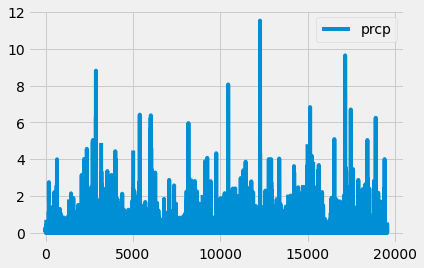

In [91]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot().get_figure()

In [92]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [93]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).distinct().count()

9

In [94]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

station_df = pd.DataFrame(results, columns = ["station", "count"])
station_df.head()

,station,count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [95]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_stations = results[0][0]
temperature = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
session.query(*temperature).all()

[(53.0, 87.0, 73.09795396419437)]

In [96]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == active_stations).filter(Measurement.date >= "2016-08-23").\
    group_by(Measurement.date).all()

temp_df = pd.DataFrame(temp_results, columns = ["date", "tobs"])
temp_df.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


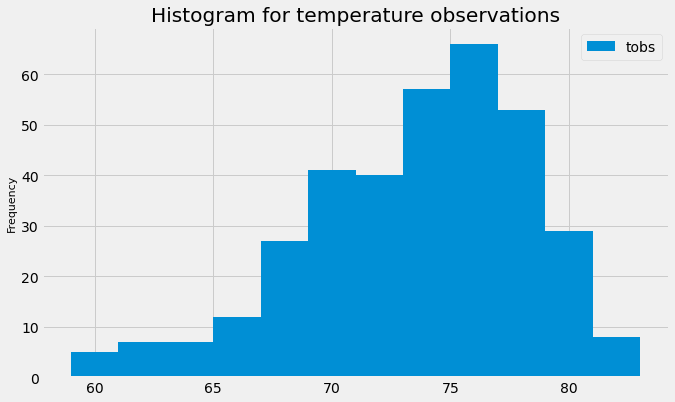

In [97]:
plt.figure(figsize=(10,6))
plt.hist(temp_df.tobs, label="tobs",bins=12)
plt.title("Histogram for temperature observations")
plt.ylabel("Frequency", fontsize=11)
plt.legend()
plt.show()

## Bonus Challenge Assignment

In [98]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01', '2017-01-31'))

[(60.0, 69.69109947643979, 81.0)]


In [99]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps_results = calc_temps("2016-01-01", "2016-01-31")
calc_temps_results

[(61.0, 69.6086956521739, 78.0)]

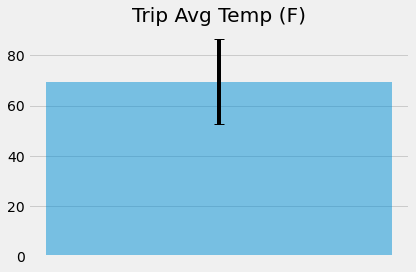

In [100]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
title = "Trip Avg Temp (F)"
error = calc_temps_results[0][2] - calc_temps_results[0][0]
plt.bar(0, calc_temps_results[0][1], yerr=error, align='center', alpha=0.5, ecolor='black', capsize=5)
plt.title(title)
plt.xticks([],[])
plt.tight_layout()
plt.savefig(f"{title}.png")
plt.show()

In [101]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

target = [Measurement.station, Station.name,\
          Station.latitude, Station.longitude,\
          Station.elevation,\
          func.avg(Measurement.prcp)]

results = session.query(*target).\
filter(Measurement.date >= "2016-06-30").\
group_by(Measurement.station).\
order_by(func.avg(Measurement.prcp).desc()).all()

print(results)

[('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.4977567567567499), ('USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.2384482758620672), ('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16408060453400347), ('USC00519523', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.1278453038674034), ('USC00514830', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.12404682274247442), ('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.07652173913043468), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.057070217917675865)]


/Users/kidistkassahun/opt/anaconda3/lib/python3.8/site-packages/sqlalchemy/sql/compiler.py:362: SAWarning: SELECT statement has a cartesian product between FROM element(s) "measurement" and FROM element "station".  Apply join condition(s) between each element to resolve.
  util.warn(message)


In [102]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
